In [15]:
import matplotlib as mp
font_size=  12
mp.rcParams['axes.labelsize'] = font_size
mp.rcParams['axes.titlesize'] = font_size
mp.rcParams['legend.fontsize'] = font_size
mp.rcParams['xtick.labelsize'] = font_size
mp.rcParams['ytick.labelsize'] = font_size

In [16]:
import os
import numpy as np
import pandas as pd
import pyranges as pr
import scanpy as sc
import scipy
import seaborn as sns
import pickle
from itertools import chain
from matplotlib import pyplot as plt

from scooby.utils.transcriptome import Transcriptome

In [17]:
data_path = '/s/project/QNA/scborzoi/submission_data/'

### Specify genome

In [18]:
gtf_file = os.path.join(data_path, "gencode.v32.annotation.sorted.gtf.gz")
fasta_file = os.path.join(data_path, "scooby_training_data", "genome_human.fa")
bed_file = os.path.join(data_path, "scooby_training_data", "sequences.bed")

In [19]:
transcriptome = Transcriptome(gtf_file)

In [20]:
gtf = pr.read_gtf(gtf_file, duplicate_attr = True)

In [21]:
cell_type_index = pd.read_parquet(os.path.join(data_path,  'scooby_training_data', 'celltype_fixed.pq'))
cell_type_index['size'] = cell_type_index['cellindex'].apply(lambda x: len(x))

In [22]:
cell_type_index['celltype_name'] = cell_type_index['celltype'].copy()
cell_type_index['celltype'] = cell_type_index['celltype'].str.replace(' ', '_').replace(r"G/M_prog", "G+M_prog").replace("MK/E_prog", "MK+E_prog")
cell_type_index = cell_type_index.sort_values('celltype')

In [23]:
cell_type_index = cell_type_index.reset_index(drop=True)

In [24]:
context_length = 524288 
clip_soft=5

### Read in adata

In [25]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed_GEX.h5ad')
)

In [26]:
ct_colors = dict(zip(adata.obs.l2_cell_type.cat.categories, adata.uns['l2_cell_type_colors']))

### Read in predicted SNPs

In [28]:
snp_preds = pd.read_pickle(os.path.join(data_path, "eQTL_preds", "susie_snps_preds_fixed.pickle")).iloc[:15900]

In [29]:
snp_preds_2 = pd.read_pickle(os.path.join(data_path, "eQTL_preds", "susie_snps_preds_fixed_16k.pickle"))

In [30]:
snp_preds = pd.concat([snp_preds, snp_preds_2])

In [31]:
snp_preds = snp_preds.dropna()

In [32]:
snp_preds = snp_preds.rename({'gene_name' : 'Gene', 'variant_hg38' : 'snp_id'}, axis = 1)

In [33]:
filter_ = snp_preds.groupby(['snp_id', 'Gene']).size().index[(snp_preds.groupby(['snp_id', 'Gene']).size() ==12).values]

In [34]:
snp_preds = snp_preds.set_index(['snp_id', 'Gene']).loc[filter_].reset_index()

In [35]:
# signed difference
def celltype_difference(df):
    # pseudobulk
    df['pred'] = df.apply((lambda x: np.array([np.log2(x['pred'][cellindex].sum() + 1) for cellindex in cell_type_index.cellindex])), axis=1)
    ref = df.query("type == 'ref'")['pred'].item()

    #df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df = df.groupby('type').agg({'difference': 'mean',}) # mean over decoy

    return df

In [36]:
def all_difference(df):
    # pseudobulk
    df['pred'] = df.apply(lambda x: np.array(np.log2(x['pred'].sum() + 1) ), axis=1)
    df['pred_sum'] = df.apply(lambda x: np.array(x['pred'].sum() ), axis=1)
    ref = df.query("type == 'ref'")['pred'].item()

    #df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df.loc[:, 'difference'] = df['pred'].apply(lambda x: x - ref)
    df = df.groupby('type').agg({'difference': 'mean',}) # mean over decoy

    return df

In [37]:
ct_differences = snp_preds.groupby(['snp_id', 'Gene']).apply(celltype_difference)

In [38]:
ct_differences = ct_differences['difference'].apply(lambda x: pd.Series(x, index=cell_type_index.celltype_name)).reset_index()

In [39]:
all_differences = snp_preds.groupby(['snp_id', 'Gene']).apply(all_difference)

In [40]:
all_differences = all_differences['difference'].apply(lambda x: pd.Series(x, index=['all'])).reset_index()

## Correlation with effect size

In [41]:
ct_colors.update({'all': 'gray'})

In [42]:
%matplotlib inline

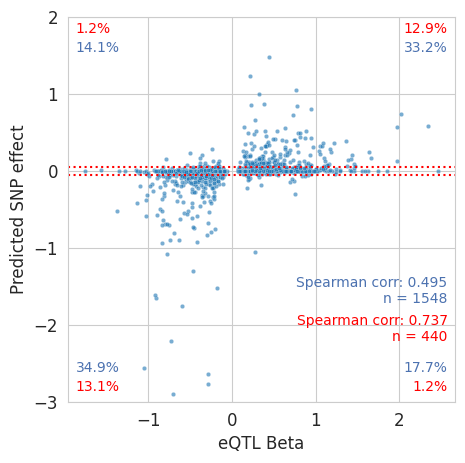

In [43]:
corr={}
auc = {}
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(5,5))
for ct in cell_type_index['celltype_name'].tolist() + ['all']:
    if ct not in ['all']:
        continue
    if ct !='all':
        sns_df = ct_differences.query("type != 'ref'").set_index(['snp_id', 'Gene'])[[ct, 'type']].melt(id_vars='type', ignore_index=False).reset_index().pivot(columns='type', values='value', index=['celltype_name', 'snp_id', 'Gene'])
    else:
        sns_df = all_differences.query("type != 'ref'").set_index(['snp_id', 'Gene'])[['all', 'type']].melt(id_vars='type', ignore_index=False).reset_index().pivot(columns='type', values='value', index=['variable', 'snp_id', 'Gene'])
    sns_df = sns_df.join(snp_preds.set_index(['snp_id', 'Gene']).query("type=='eSNP'").drop('pred', axis=1), on=['snp_id', 'Gene'])
    # break

    sns_df['eSNP'] = sns_df['eSNP'].clip(lower=-2.9)
    sns.scatterplot(data=sns_df, y='eSNP', x='beta_posterior',  alpha=0.6, s = 10, ax=ax)
    ax.set_xlabel('eQTL Beta')
    ax.set_ylabel('Predicted SNP effect')
    ax.set_ylim((-3,2))
    corr.update({ct: scipy.stats.spearmanr(sns_df['eSNP'], sns_df['beta_posterior'])[0]})
    quadrant_1 = sum(np.logical_and(sns_df['eSNP'] < 0, sns_df['beta_posterior'] < 0))/len(sns_df)
    quadrant_2 = sum(np.logical_and(sns_df['eSNP'] > 0, sns_df['beta_posterior'] < 0))/len(sns_df)
    quadrant_3 = sum(np.logical_and(sns_df['eSNP'] < 0, sns_df['beta_posterior'] > 0))/len(sns_df)
    quadrant_4 = sum(np.logical_and(sns_df['eSNP'] > 0, sns_df['beta_posterior'] > 0))/len(sns_df)
    fig.text(0.02, 0.07, f"{(quadrant_1 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
    fig.text(0.02, 0.90, f"{(quadrant_2 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
    fig.text(0.98, 0.07, f"{(quadrant_3 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
    fig.text(0.98, 0.90, f"{(quadrant_4 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')


    quadrant_1 = sum(np.logical_and(sns_df['eSNP'] < -0.05, sns_df['beta_posterior'] < -0.05))/len(sns_df)
    quadrant_2 = sum(np.logical_and(sns_df['eSNP'] > 0.05, sns_df['beta_posterior'] < -0.05))/len(sns_df)
    quadrant_3 = sum(np.logical_and(sns_df['eSNP'] < -0.05, sns_df['beta_posterior'] > 0.05))/len(sns_df)
    quadrant_4 = sum(np.logical_and(sns_df['eSNP'] > 0.05, sns_df['beta_posterior'] > 0.05))/len(sns_df)
    fig.text(0.02, 0.02, f"{(quadrant_1 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = 'r')
    fig.text(0.02, 0.95, f"{(quadrant_2 * 100):.1f}%", ha='left', va='bottom', fontsize=10, transform=ax.transAxes, color = 'r')
    fig.text(0.98, 0.02, f"{(quadrant_3 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'r')
    fig.text(0.98, 0.95, f"{(quadrant_4 * 100):.1f}%", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'r')

    # ax.axvline(0.05, linestyle = ':', color ='r')
    # ax.axvline(-0.05, linestyle = ':', color ='r')
    ax.axhline(0.05, linestyle = ':', color ='r')
    ax.axhline(-0.05, linestyle = ':', color ='r')
    red_corr = scipy.stats.spearmanr(sns_df[(sns_df['eSNP'] > 0.05) | (sns_df['eSNP'] < -0.05)]['eSNP'], sns_df[(sns_df['eSNP'] > 0.05) | (sns_df['eSNP'] < -0.05)]['beta_posterior'])[0]
    fig.text(0.98, 0.25, f"Spearman corr: {np.round(corr[ct],3)}\nn = {len(sns_df)}", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = '#4c72b0')
    fig.text(0.98, 0.15, f"Spearman corr: {np.round(red_corr,3)}\nn = {len(sns_df[(sns_df['eSNP'] > 0.05) | (sns_df['eSNP'] < -0.05)])}", ha='right', va='bottom', fontsize=10, transform=ax.transAxes, color = 'r')
    
# fig.savefig('../figures/figures/Figure4/effect_size_correlation.png', dpi=300, bbox_inches ='tight')
    

In [47]:
transcripts = gtf.df[(gtf.df.Feature == 'transcript') ]
def select_transcript(df):
    if df.tag.str.contains('MANE_Select').any():
        return df[df.tag.str.contains('MANE_Select').fillna(False)]
    elif not df.tag.str.contains('MANE_Select').any() and df.tag.str.contains('appris_principal_1').any():
        return df[df.tag.str.contains('appris_principal_1').fillna(False)]
    elif not df.tag.str.contains('MANE_Select').any() and not df.tag.str.contains('appris_principal_1').any() and df.tag.str.contains('basic').any():
        return df[df.tag.str.contains('basic').fillna(False)]

In [48]:
principal_transcripts = transcripts.groupby('gene_id').apply(select_transcript)
principal_transcripts = principal_transcripts.drop_duplicates('gene_name')

In [49]:
principal_transcripts['gene_id_split'] = principal_transcripts['gene_id'].str.split('.').str[0]
principal_transcripts

,,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,gene_type,...,transcript_name,transcript_support_level,tag,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_id_split
gene_id,,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.15,2871237,chrX,HAVANA,transcript,100627107,100636806,.,-,.,ENSG00000000003.15,protein_coding,...,TSPAN6-201,1,"basic,MANE_Select,appris_principal_1,CCDS",OTTHUMT00000057483.2,NaN,NaN,NaN,ENSP00000362111.4,CCDS14470.1,ENSG00000000003
ENSG00000000005.6,2823484,chrX,HAVANA,transcript,100584935,100599885,.,+,.,ENSG00000000005.6,protein_coding,...,TNMD-201,1,"basic,MANE_Select,appris_principal_1,CCDS",OTTHUMT00000057481.2,NaN,NaN,NaN,ENSP00000362122.4,CCDS14469.1,ENSG00000000005
ENSG00000000419.12,2695724,chr20,HAVANA,transcript,50934866,50958550,.,-,.,ENSG00000000419.12,protein_coding,...,DPM1-203,1,"basic,appris_principal_1,CCDS",OTTHUMT00000079716.1,NaN,NaN,NaN,ENSP00000360644.5,CCDS13434.1,ENSG00000000419
ENSG00000000457.14,236954,chr1,HAVANA,transcript,169849630,169893896,.,-,.,ENSG00000000457.14,protein_coding,...,SCYL3-202,1,"basic,MANE_Select,appris_alternative_2,CCDS",OTTHUMT00000087548.5,NaN,NaN,NaN,ENSP00000356745.5,CCDS1286.1,ENSG00000000457
ENSG00000000460.17,101903,chr1,HAVANA,transcript,169795039,169854080,.,+,.,ENSG00000000460.17,protein_coding,...,C1orf112-202,1,"alternative_5_UTR,basic,MANE_Select,appris_pri...",OTTHUMT00000087235.4,NaN,NaN,NaN,ENSP00000352276.4,CCDS1285.1,ENSG00000000460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000288459.1,1942596,chr14,HAVANA,transcript,104293677,104294921,.,+,.,ENSG00000288459.1,lncRNA,...,AL512357.2-201,NaN,basic,OTTHUMT00000529240.1,NaN,NaN,NaN,NaN,NaN,ENSG00000288459
ENSG00000288460.1,229288,chr1,HAVANA,transcript,158127286,158128301,.,-,.,ENSG00000288460.1,protein_coding,...,AL138899.3-201,NaN,"CAGE_supported_TSS,RNA_Seq_supported_only,basi...",OTTHUMT00000504892.1,NaN,NaN,NaN,ENSP00000499955.1,NaN,ENSG00000288460
ENSG00000288473.1,933074,chr6,HAVANA,transcript,30908241,30926459,.,+,.,ENSG00000288473.1,lncRNA,...,AL669830.1-201,2,"basic,readthrough_transcript",OTTHUMT00000076565.2,NaN,NaN,NaN,NaN,NaN,ENSG00000288473


In [50]:
def select_start_end(x):
    if x['Strand'] == '+':
        return np.abs(x['Start_x'] - x['Start_y'])
    else:
        return np.abs(x['End'] - x['Start_y'])
sign_concordant = sns_df#[(np.sign(sns_df['beta_posterior'].values) == np.sign(sns_df['eSNP'].values))]
merged_tss_dist = principal_transcripts.reset_index(drop = True).merge(sign_concordant, left_on = 'gene_id_split', right_on = 'gene_id_split' )
merged_tss_dist['distance'] = merged_tss_dist.apply(lambda x : select_start_end(x), axis = 1)

In [51]:
merged_tss_dist['distance_log'] = np.log10(merged_tss_dist['distance'])

In [52]:
edges = [0, 1000, 2000, 5000, 10000, 20000, 50000, 100000, 150000, 262144]

In [53]:
new_edges = edges
merged_tss_dist['distance_bin']  = pd.cut(merged_tss_dist['distance'], bins = new_edges,include_lowest=True, precision = 0)

In [54]:
def get_in_vs_out(x):
    all_len = len(x)
    x = x[x['eSNP'].abs() > 0.05]
    quadrant_1 = sum(np.logical_and(x['eSNP'] < 0, x['beta_posterior'] < 0))/all_len
    quadrant_4 = sum(np.logical_and(x['eSNP'] > 0, x['beta_posterior'] > 0))/all_len
    all_len = quadrant_1 + quadrant_4
    return all_len
distance_to_tss_df = merged_tss_dist.groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()

In [55]:
distance_to_tss_df_subset  = merged_tss_dist[(merged_tss_dist['eSNP'] > 0.05) | (merged_tss_dist['eSNP'] < -0.05)].groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()
distance_to_tss_df_subset['Set'] = 'Pred. abs. effect > 3.5%'

In [56]:
distance_to_tss_df = merged_tss_dist.groupby('distance_bin').apply(lambda x : get_in_vs_out(x)).to_frame()
distance_to_tss_df['Set'] = 'No filtering'

In [57]:
distance_to_tss_df = pd.concat([distance_to_tss_df,distance_to_tss_df_subset])

In [58]:
ns_all = merged_tss_dist.groupby(merged_tss_dist.distance_bin).count()['distance'].values
ns_subset = merged_tss_dist[(merged_tss_dist['eSNP'] > 0.05) | (merged_tss_dist['eSNP'] < -0.05)].groupby('distance_bin').count()['distance'].values
ns = list(chain.from_iterable(zip(ns_all, ns_subset)))

/scratch/tmp/hingerl/ipykernel_3260593/2947915961.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="center")
/scratch/tmp/hingerl/ipykernel_3260593/2947915961.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


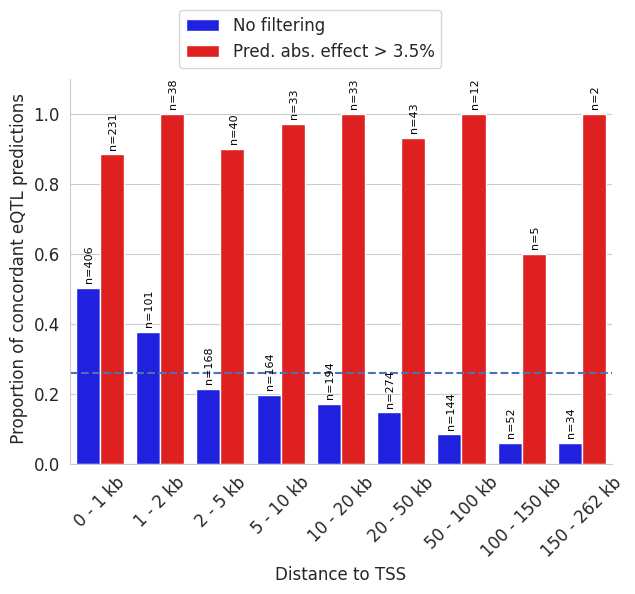

In [41]:
fig, ax = plt.subplots(figsize=(7,5))
sns.barplot(distance_to_tss_df, x = 'distance_bin', y = 0, hue = 'Set',  palette = ['b', 'r'], ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="center")
labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = []
for i,l in enumerate(labels):
    stripped = l.strip('(').strip(')').strip('[').strip(']').split(',')
    new_labels.append(" - ".join([str(int(s)//1000) for s in stripped]) + f" kb")
for i,(index, row) in enumerate(distance_to_tss_df.sort_index().iterrows()):
    if (i %2 == 0):
        ax.text(ax.get_xticks()[i//2]-0.18, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
    else:
        ax.text(ax.get_xticks()[i//2]+0.22, row[0]+ 0.02, f"n={ns[i]}", color='black', ha="center", rotation = 90, fontsize = 8)
new_labels[0] = f"0 - 1 kb"
ax.set_xticklabels(new_labels)
ax.legend(bbox_to_anchor=(.7, 1.2))
ax.axhline(0.26, linestyle = '--', color = '#4c72b0')
ax.set_ylim(0,1.1)
ax.set_xlabel("Distance to TSS")
ax.set_ylabel(" Proportion of concordant eQTL predictions")
sns.despine()
# fig.savefig("../figures/figures/Figure4/distance_to_TSS_perf.png", dpi = 300, bbox_inches ='tight')